In [2]:
# setup & import

#imports
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define our cohort name (matching the folder in 'data/')
cohort = "mimic_cohort_NF_30_days"

In [4]:
#Loading cohort file

try:
    # Load Target Labels
    target = pd.read_csv(f"../data/{cohort}/{cohort}.csv.gz", compression="gzip", index_col=0)
    # Load ICD Codes
    icd_codes_data = pd.read_csv(f"../data/{cohort}/{cohort}_icd_codes.csv.gz", compression="gzip", index_col=0)
    print("File loaded successfully.")
except FileNotFoundError:
    print("\n FileNotFoundError: The file was not found at that path. please double check")
except Exception as e:
    print(e)

#ICD preprocessing (grouping first 3 chars + merge age/gender)

icd_codes_data["icd_code_group"] = icd_codes_data["icd_code"].str[:3]  #selecting first 3 characters of ICD code

icd_codes_data = icd_codes_data.merge(
    target[["hadm_id", "age", "gender"]],
    on=["subject_id", "hadm_id"],
    how="left")
display(icd_codes_data)

File loaded successfully.


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_code_group,age,gender
0,10010231,21586397,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
1,10010231,21586397,2,C9200,10,"Acute myeloblastic leukemia, not having achiev...",C92,57,M
2,10010231,23835132,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
3,10010231,23835132,2,C92Z0,10,Other myeloid leukemia not having achieved rem...,C92,57,M
4,10010231,23835132,3,K760,10,"Fatty (change of) liver, not elsewhere classified",K76,57,M
...,...,...,...,...,...,...,...,...,...
79009,19999784,29956342,1,Z5111,10,Encounter for antineoplastic chemotherapy,Z51,57,M
79010,19999784,29956342,2,C8589,10,"Other specified types of non-Hodgkin lymphoma,...",C85,57,M
79011,19999784,29956342,3,E876,10,Hypokalemia,E87,57,M
79012,19999784,29956342,4,Z87891,10,Personal history of nicotine dependence,Z87,57,M


In [5]:
# 1. Create Full Codes Matrix 
print("Generating X_full (Full Codes)...")
X_full = icd_codes_data.groupby(["hadm_id", "icd_code"]).size().unstack("icd_code").fillna(0).astype(int)
X_full = (X_full > 0).astype(int)

# 2. Create Groups Matrix (First 3 chars)
print("Generating X_groups (Code Groups)...")
X_groups = icd_codes_data.groupby(["hadm_id", "icd_code_group"]).size().unstack("icd_code_group").fillna(0).astype(int)
X_groups = (X_groups > 0).astype(int)

# Ensure X_groups has same rows/indices as X_full (align patients)
X_groups = X_groups.reindex(X_full.index, fill_value=0)

# 3. Create Combined Matrix (Full+Groups)
print("Generating X_combined (Combined)...")
X_combined = pd.concat([X_full, X_groups], axis=1)

print(f"Dimensions:")
print(f"X_full:     {X_full.shape}")
print(f"X_groups:   {X_groups.shape}")
print(f"X_combined: {X_combined.shape}")

Generating X_full (Full Codes)...
Generating X_groups (Code Groups)...
Generating X_combined (Combined)...
Dimensions:
X_full:     (5308, 3940)
X_groups:   (5308, 996)
X_combined: (5308, 4936)


In [6]:
# Load the 5-fold splits

with open(f'../data/{cohort}/cv_folds/fold_0.pkl', 'rb') as file:
    train_split, val_split, test_split = pickle.load(file)

fold_ids = []
for fold in range(5):
    with open(f'../data/{cohort}/cv_folds/fold_{fold}.pkl', 'rb') as f:
        train_split, val_split, test_split = pickle.load(f)
        train_split = np.concatenate([train_split, val_split])
        train_ids = train_split[:,1]  # hadm_id
        test_ids = test_split[:,1]
        fold_ids.append((train_ids, test_ids))
print("Folds loaded")

Folds loaded


In [7]:
# Model Configuration

models_config = {
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42),

    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42),
    
    "CatBoost": CatBoostClassifier(
        iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)
}

feature_datasets = {
    "Full Codes": X_full,
    "Groups": X_groups,
    "Combined": X_combined
}

results_data = []

for feat_name, X_data in feature_datasets.items():
    print(f"--- Processing Features: {feat_name} ---")
    
    for model_name, base_model in models_config.items():
        print(f"  Training {model_name}...", end=" ")        
        fold_scores = {'AUC': [], 'F1': [], 'Acc': [], 'Prec': [], 'Rec': []}
        
        # Looping over folds
        for fold_idx, (train_ids, test_ids) in enumerate(fold_ids): 
            # Ensuring we only select IDs that exist in our X matrix to avoid errors
            valid_train = [uid for uid in train_ids if uid in X_data.index]
            valid_test = [uid for uid in test_ids if uid in X_data.index]
            
            X_train, X_test = X_data.loc[valid_train], X_data.loc[valid_test]
            y_train = target.set_index('hadm_id').loc[valid_train]['label']
            y_test = target.set_index('hadm_id').loc[valid_test]['label']
            
            # Create a FRESH model clone for this fold
            model = clone(base_model)
            
            # Handling Imbalance (Dynamic Scale Pos Weight)
            if model_name in ["XGBoost", "CatBoost"]:
                ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
                model.set_params(scale_pos_weight=ratio)
            
            # Train & Predict (using the fresh model, and not the base_model)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            # Metrics
            fold_scores['AUC'].append(roc_auc_score(y_test, y_prob))
            fold_scores['F1'].append(f1_score(y_test, y_pred))
            fold_scores['Acc'].append(accuracy_score(y_test, y_pred))
            fold_scores['Prec'].append(precision_score(y_test, y_pred, zero_division=0))
            fold_scores['Rec'].append(recall_score(y_test, y_pred))
            
        # Aggregate results for this Model + Feature combo
        avg_auc = np.mean(fold_scores['AUC'])
        print(f"-> Avg AUC: {avg_auc:.4f}")
        
        results_data.append({
            "Model": model_name,
            "Features": feat_name,
            "AUC": avg_auc,
            "F1": np.mean(fold_scores['F1']),
            "Accuracy": np.mean(fold_scores['Acc']),
            "Precision": np.mean(fold_scores['Prec']),
            "Recall": np.mean(fold_scores['Rec'])
        })

# Display Final Summary Table

print(f"\n Summary Table")
summary_df = pd.DataFrame(results_data)
auc_pivot = summary_df.pivot(index="Model", columns="Features", values="AUC")
display(auc_pivot)



--- Processing Features: Full Codes ---
  Training XGBoost... -> Avg AUC: 0.6806
  Training RandomForest... -> Avg AUC: 0.7007
  Training CatBoost... -> Avg AUC: 0.7255
--- Processing Features: Groups ---
  Training XGBoost... -> Avg AUC: 0.6754
  Training RandomForest... -> Avg AUC: 0.6879
  Training CatBoost... -> Avg AUC: 0.6895
--- Processing Features: Combined ---
  Training XGBoost... -> Avg AUC: 0.6839
  Training RandomForest... -> Avg AUC: 0.7109
  Training CatBoost... -> Avg AUC: 0.7239

 Summary Table


Features,Combined,Full Codes,Groups
Model,,,
CatBoost,0.723852,0.725487,0.689526
RandomForest,0.710934,0.700713,0.687941
XGBoost,0.683946,0.680647,0.675399


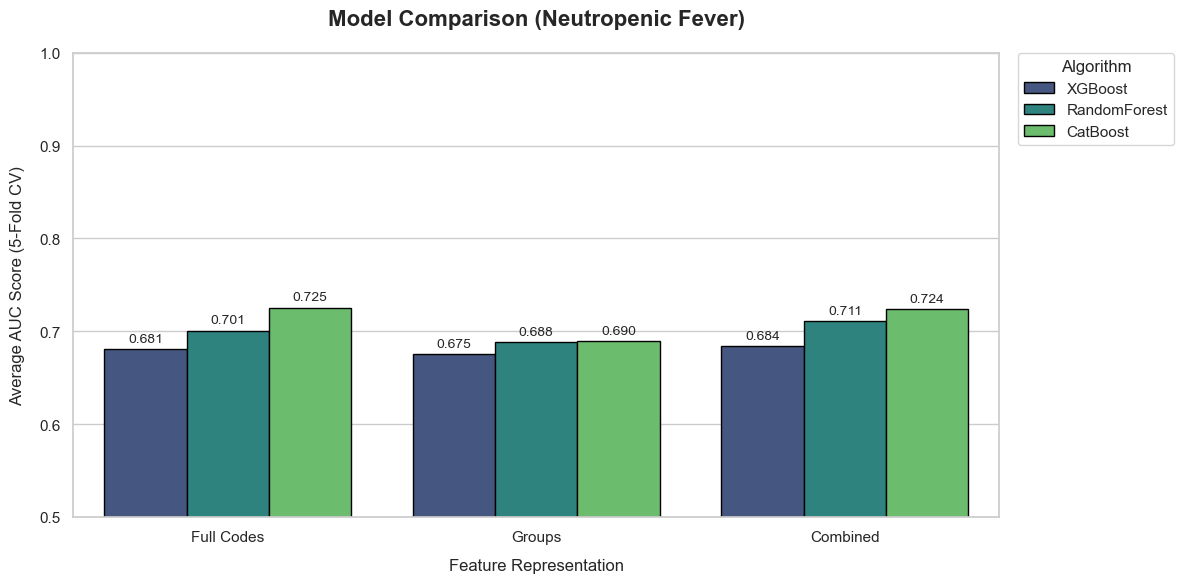

In [8]:
# Plots

sns.set_theme(style="whitegrid")
# Creating the Plot
plt.figure(figsize=(12, 6))

# Bar Plot: X-axis = Features, Y-axis = AUC, Color = Model
ax = sns.barplot(
    data=summary_df,
    x="Features", y="AUC", hue="Model", palette="viridis", edgecolor="black")

plt.title("Model Comparison (Neutropenic Fever)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Feature Representation", fontsize=12, labelpad=10)
plt.ylabel("Average AUC Score (5-Fold CV)", fontsize=12, labelpad=10)
plt.ylim(0.5, 1.0) 

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Algorithm', borderaxespad=0)
plt.tight_layout()
plt.show()



--- Selecting Best Model Configuration ---
WINNER: CatBoost using Full Codes (Avg AUC: 0.7255)
Training final CatBoost model on 5308 samples (for saving)...

--- Generating Corrected Plots (Aggregating CV Predictions) ---
Aggregate AUC (on CV Test Folds): 0.7280


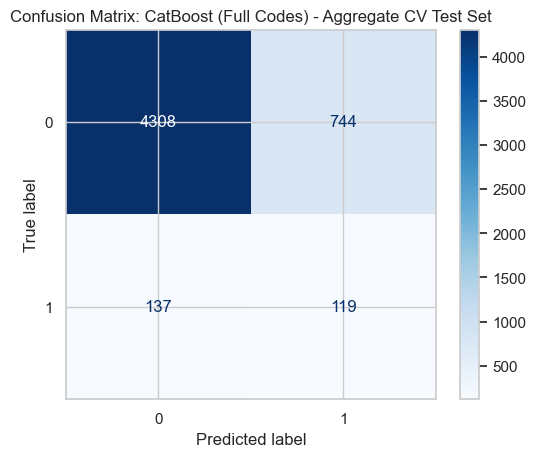

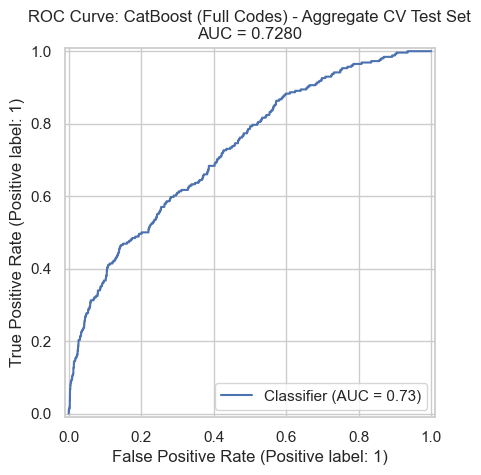

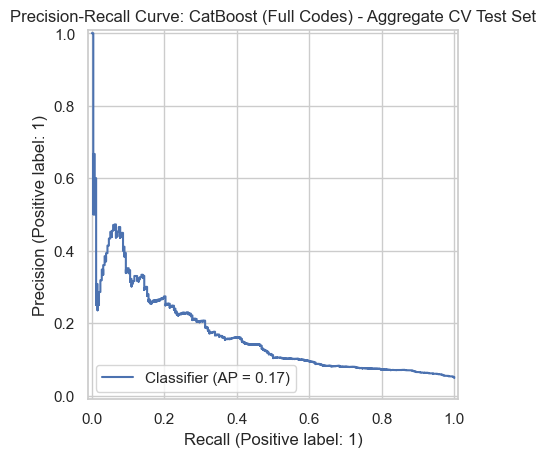


Final model saved successfully: ../models/mimic_cohort_NF_30_days_CatBoost_Full_Codes_model.pkl


In [10]:
# Final Model selection and training
print("\n--- Selecting Best Model Configuration ---")

# Best configuration based on Maximum AUC
best_row = summary_df.loc[summary_df['AUC'].idxmax()]

best_model_name = best_row['Model']
best_features_name = best_row['Features']
best_auc = best_row['AUC']

print(f"WINNER: {best_model_name} using {best_features_name} (Avg AUC: {best_auc:.4f})")

# Get the full feature matrix for the winner
if best_features_name == "Full Codes":
    X_final = X_full
elif best_features_name == "Groups":
    X_final = X_groups
elif best_features_name == "Combined":
    X_final = X_combined
else:
    raise ValueError("Feature set name not recognized for final training.")

# Re-instantiate the winning model and calculate final scale_pos_weight
y_final = target.set_index('hadm_id').loc[X_final.index]['label']

if best_model_name == "XGBoost":
    final_model = XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    # RF doesn't use scale_pos_weight, it uses class_weight="balanced"
    final_model = RandomForestClassifier(
        n_estimators=500, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

# Apply scale_pos_weight if it's a boosting model (using the full dataset ratio)
if best_model_name in ["XGBoost", "CatBoost"]:
    final_ratio = float(np.sum(y_final == 0)) / np.sum(y_final == 1)
    final_model.set_params(scale_pos_weight=final_ratio)
    
# Train the final model on ALL data (This model is saved for deployment)
print(f"Training final {best_model_name} model on {len(X_final)} samples (for saving)...")
final_model.fit(X_final, y_final)

print("\n--- Generating Corrected Plots (Aggregating CV Predictions) ---")

X_data_for_cv = X_final # Use the selected feature set
y_data_for_cv = y_final

# Clone the base model parameters used during the CV search (N=200 estimators)
if best_model_name == "XGBoost":
    cv_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    cv_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    cv_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

all_y_test_agg = []
all_y_pred_agg = []
all_y_prob_agg = []

for train_ids, test_ids in fold_ids: 
    # Filter IDs to ensure they exist in the final selected feature matrix
    valid_train = [uid for uid in train_ids if uid in X_data_for_cv.index]
    valid_test = [uid for uid in test_ids if uid in X_data_for_cv.index]
    
    X_train, X_test = X_data_for_cv.loc[valid_train], X_data_for_cv.loc[valid_test]
    y_train = y_data_for_cv.loc[valid_train]
    y_test = y_data_for_cv.loc[valid_test]
    
    model = clone(cv_model)
    
    if best_model_name in ["XGBoost", "CatBoost"]:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
        model.set_params(scale_pos_weight=ratio)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    all_y_test_agg.extend(y_test)
    all_y_pred_agg.extend(y_pred)
    all_y_prob_agg.extend(y_prob)

all_y_test_agg = np.array(all_y_test_agg)
all_y_pred_agg = np.array(all_y_pred_agg)
all_y_prob_agg = np.array(all_y_prob_agg)

# Calculate the single aggregate metrics
agg_auc_final = roc_auc_score(all_y_test_agg, all_y_prob_agg)
print(f"Aggregate AUC (on CV Test Folds): {agg_auc_final:.4f}")

# Plotting with the CORRECTED aggregate data (non-overfit)
plot_title = f"{best_model_name} ({best_features_name}) - Aggregate CV Test Set"

# Confusion Matrix Plot
cm = confusion_matrix(all_y_test_agg, all_y_pred_agg)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: {plot_title}")
plt.show()

# ROC Curve Plot 
RocCurveDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"ROC Curve: {plot_title}\nAUC = {agg_auc_final:.4f}")
plt.show()

# Precision-Recall Curve Plot 
PrecisionRecallDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"Precision-Recall Curve: {plot_title}")
plt.show()

# Save the final model (the one trained on ALL data) using joblib
model_filename = f"../models/{cohort}_{best_model_name}_{best_features_name.replace(' ', '_')}_model.pkl"
joblib.dump(final_model, model_filename)

print(f"\nFinal model saved successfully: {model_filename}")